# NYC Yellow Taxi Trip Analysis

Analysis is part of the 4th semsester course Database Technologies. Where Students analysie a choosen dataset.

### Daten
- TLC Trip Recrod Data from 2022 yellow taxi trips
    - Explanation: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf  
- Taxi Zone Lookup Table
- Taxi Zone Shapefile
Link: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Zurzeit waren für 2022 nur Daten bis März verfügabr.
Daten wurde über AWS-cli heruntergeladen:

`aws s3 cp --no-sign-request s3://nyc-tlc/trip\ data/yellow_tripdata_2022-01.parquet .`  
`aws s3 cp --no-sign-request s3://nyc-tlc/trip\ data/yellow_tripdata_2022-02.parquet .`  
`aws s3 cp --no-sign-request s3://nyc-tlc/trip\ data/yellow_tripdata_2022-03.parquet .`  

Datenformat: Umstellung auf parquet



Yellow Taxi?
- Yellow taxicabs are the iconic, yellow vehicles that have the right to pick up street-hailing passengers anwhere in New York City. 
- https://www1.nyc.gov/site/tlc/vehicles/get-a-vehicle-license.page

### Explanation of the Attributes

1. `VendorID` - von welchem Provider kommen die Daten
    - 1=Createive Mobile Technologies LLC; 2=VeriFone Inc.
2. `tpep_pickup_datetime` - datetime when the meter was engaged
3. `tpep_dropoff_datetime` - datetime wehn the meter was disengaged
4. `passenger_count` - number of passengers (enterd by driver)
5. `trip_distance` - miles reported by the taximeter
6. `PULocationID` - TLC Taxi Zone (where the taximeter was engaged)
7. `DOLocationID` - TLC Taxi Zone (where the taximeter was disengaged)
8. `RateCodeID` - final rate code in effect at the end of the trip
    - 1=Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride
9. `store_and_fwd_flag` - when record was not send immediately, and held in vehicle memory
    - Y=store and forward trip, N=not a store and forward
10. `payment_type` - numeric code signifiying how the passenger paid of the trip
    - 0=Credit card, 1=Cash, 2=No charge, 3=Dispute, 4=Unkown, 5=Voided trip
11. `fare_amount` - The time-and-distance fare calculated by the meter
12. `extra` - Miscelleneous extras and surcharges. $0.5 and $1 rush hour and overnight charges
13. `mTA_tax` - $0.5 MTA tax that is automatically tiggered
14. `improvement_surcharge` - $0.3 imporvement surcharge assessed trips at the flag drop 
15. `tip_amount` - automatically populated for credit card tips. Cash tips are not included
16. `tolls_amount` - Maut gebühren
17. `total_amount` - total amount charged to passengers. Does not include chash tips.
18. `congestion_Surcharge` - Stauzuschlag
19. `airport_fee` $1.25 for pick up only at LaGuardia and John F. Kennedy Airpors


## ToDo's
- calculate trip duration
- calculate average speed from ratio trip distance and trip time
- look at trips with 0 distance or miles if the fare was negotiaited and location changed
- check trip distance
    - change miles to km
- wohin fahren Taxis vom airport aus?   
    - Indentifiziern von aiports rides?
        - which originated ate the 3 NYC area airports (JFK, LGA, EWR)
        - rate code: 2

### Imports

In [1]:
import pandas as pd
# turn off truncating display option
pd.set_option('display.max_columns', None)
import numpy as np

### Libs for viszalization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Einlesen der Daten

In [2]:
# See related data
!ls | grep 'yellow*'

yellow_tripdata_2022-01.parquet
yellow_tripdata_2022-02.parquet
yellow_tripdata_2022-03.parquet


In [3]:
# read data into a pandas DataFrame
df_01 = pd.read_parquet("yellow_tripdata_2022-01.parquet", engine='pyarrow')
df_02 = pd.read_parquet("yellow_tripdata_2022-02.parquet", engine='pyarrow')
df_03 = pd.read_parquet("yellow_tripdata_2022-03.parquet", engine='pyarrow')

df_list = [df_01, df_02, df_03]

### Data Understanding

In [4]:
for df in df_list:
    df.info()
    print('#'*30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [5]:
for df in df_list:
    print(df.shape[1])

19
19
19


In [6]:
df_01.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [7]:
df.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3627877,2,2022-03-31 23:45:00,2022-04-01 00:01:00,NaN,3.57,NaN,None,48,262,0,18.33,0.0,0.5,1.00,0.0,0.3,22.63,NaN,NaN
3627878,2,2022-03-31 23:59:39,2022-04-01 00:06:09,NaN,2.04,NaN,None,48,238,0,9.75,0.0,0.5,2.00,0.0,0.3,15.05,NaN,NaN
3627879,2,2022-03-31 23:50:00,2022-04-01 00:08:00,NaN,0.59,NaN,None,48,4,0,17.33,0.0,0.5,2.23,0.0,0.3,22.86,NaN,NaN
3627880,2,2022-03-31 23:25:56,2022-03-31 23:32:37,NaN,1.26,NaN,None,158,68,0,8.80,0.0,0.5,2.57,0.0,0.3,14.67,NaN,NaN
3627881,2,2022-03-31 23:08:00,2022-03-31 23:17:00,NaN,1.66,NaN,None,112,256,0,8.80,0.0,0.5,1.82,0.0,0.3,11.42,NaN,NaN


In [8]:
df_01['passenger_count'].value_counts()

1.0    1794055
2.0     343026
3.0      84570
0.0      52061
5.0      51338
4.0      35321
6.0      32037
7.0          9
8.0          8
9.0          3
Name: passenger_count, dtype: int64

In [9]:
df_01['RatecodeID'].value_counts()

1.0     2296363
2.0       66623
5.0       13561
99.0       8732
3.0        4014
4.0        3118
6.0          17
Name: RatecodeID, dtype: int64

In [10]:
df_01['store_and_fwd_flag'].value_counts()

N    2337496
Y      54932
Name: store_and_fwd_flag, dtype: int64

In [11]:
df_01['payment_type'].value_counts()

1    1874874
2     495171
0      71503
3      11709
4      10673
5          1
Name: payment_type, dtype: int64

#### Data Understanding Summary
- `passenger_count` and `RatecodeID` should be an int   
- the columns are the same so we can concatinate the dataframe to create one dataframe
- there are missing values
- `PULocationID` and `DOLocationID` are keys for zones in a different table provided by TLC
    - make a left join to have more context what each zone number means
- Yellow Trips Data Dictionary doesn't fit the data
    - `payment_type` starts with 0, not with 1 
    - 99 encoding in `RatecodeID`
- Use pickup and dropoff time to calculate duration

### Preprocessing
- concat DFs
- join data
- change data type
- calculate trip duration 
- calculate average speed from duration and distance

#### CONCAT DataFrames
- Erstellen von einem eizelnen Datansatz mit allen drei Monaten

In [12]:
# before concat check if columns are equal
if not (df_01.columns == df_02.columns).all() and (df_01.columns == df_03.columns).all():
    print("Columns are different")

In [13]:
df_full = pd.concat(df_list)

In [14]:
df_full

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3627877,2,2022-03-31 23:45:00,2022-04-01 00:01:00,NaN,3.57,NaN,None,48,262,0,18.33,0.0,0.5,1.00,0.0,0.3,22.63,NaN,NaN
3627878,2,2022-03-31 23:59:39,2022-04-01 00:06:09,NaN,2.04,NaN,None,48,238,0,9.75,0.0,0.5,2.00,0.0,0.3,15.05,NaN,NaN
3627879,2,2022-03-31 23:50:00,2022-04-01 00:08:00,NaN,0.59,NaN,None,48,4,0,17.33,0.0,0.5,2.23,0.0,0.3,22.86,NaN,NaN
3627880,2,2022-03-31 23:25:56,2022-03-31 23:32:37,NaN,1.26,NaN,None,158,68,0,8.80,0.0,0.5,2.57,0.0,0.3,14.67,NaN,NaN


In [15]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9071244 entries, 0 to 3627881
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [16]:
# delte variables for each dataframe to free up memory
del df_01
del df_02
del df_03
del df_list

#### JOIN with Taxi Zones
- on PULocationID
- on DOLocationID

In [17]:
df_taxi_zone = pd.read_csv("taxi+_zone_lookup.csv")

In [18]:
df_taxi_zone

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [19]:
df_taxi_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


In [20]:
df_full.PULocationID

0          142
1          236
2          166
3          114
4           68
          ... 
3627877     48
3627878     48
3627879     48
3627880    158
3627881    112
Name: PULocationID, Length: 9071244, dtype: int64

In [21]:
df_merge_location = pd.merge(df_full, df_taxi_zone, left_on="PULocationID", right_on="LocationID", how="left")

In [22]:
df_merge_location[["PULocationID", "LocationID"]]

,PULocationID,LocationID
0,142,142
1,236,236
2,166,166
3,114,114
4,68,68
...,...,...
9071239,48,48
9071240,48,48
9071241,48,48
9071242,158,158


In [23]:
# check for equality
# when true, then merge was sucessful
df_merge_location["PULocationID"].equals(df_merge_location["LocationID"])

True

In [24]:
# rename new columns
df_merge_location.rename(columns={'Borough': 'PULocation_Borough', 'Zone': 'PULocation_Zone', 'service_zone': 'PULocation_service_zone'}, inplace=True)

In [25]:
# drop LocationID
df_merge_location.drop("LocationID", axis=1, inplace=True)

In [26]:
df_merge_location.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee',
       'PULocation_Borough', 'PULocation_Zone', 'PULocation_service_zone'],
      dtype='object')

##### Merge with DOLocationID for dropoff

In [27]:
df_merge_location = pd.merge(df_merge_location, df_taxi_zone, left_on="DOLocationID", right_on="LocationID", how="left")

In [ ]:
df_merge_location.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee',
       'PULocation_Borough', 'PULocation_Zone', 'PULocation_service_zone',
       'LocationID', 'Borough', 'Zone', 'service_zone'],
      dtype='object')

In [28]:
df_merge_location["DOLocationID"].equals(df_merge_location["LocationID"])

True

In [29]:
df_merge_location.rename(columns={'Borough': 'DOLocation_Borough', 'Zone': 'DOLocation_Zone', 'service_zone': 'DOLocation_service_zone'}, inplace=True)
df_merge_location.drop("LocationID", axis=1, inplace=True)

In [30]:
df_merge_location.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee',
       'PULocation_Borough', 'PULocation_Zone', 'PULocation_service_zone',
       'DOLocation_Borough', 'DOLocation_Zone', 'DOLocation_service_zone'],
      dtype='object')

In [31]:
del df_full

#### Transform Columns to int
- `passenger_count` and `RatecodeID` should be int
- to convert to int I need to fill NaN's 
    - used 99 to indicate missing vlaues

In [32]:
df_merge_location['passenger_count'] = df_merge_location['passenger_count'].fillna(99)
df_merge_location['passenger_count'] = df_merge_location['passenger_count'].astype('int64')
df_merge_location['RatecodeID'] = df_merge_location['RatecodeID'].fillna(99)
df_merge_location['RatecodeID'] = df_merge_location['RatecodeID'].astype('int64')

In [33]:
df_merge_location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9071244 entries, 0 to 9071243
Data columns (total 25 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   VendorID                 int64         
 1   tpep_pickup_datetime     datetime64[ns]
 2   tpep_dropoff_datetime    datetime64[ns]
 3   passenger_count          int64         
 4   trip_distance            float64       
 5   RatecodeID               int64         
 6   store_and_fwd_flag       object        
 7   PULocationID             int64         
 8   DOLocationID             int64         
 9   payment_type             int64         
 10  fare_amount              float64       
 11  extra                    float64       
 12  mta_tax                  float64       
 13  tip_amount               float64       
 14  tolls_amount             float64       
 15  improvement_surcharge    float64       
 16  total_amount             float64       
 17  congestion_surcharge     fl

#### Calculate trip duration

In [34]:
df_merge_location['trip_duration'] = df_merge_location.tpep_dropoff_datetime - df_merge_location.tpep_pickup_datetime 

In [35]:
df_merge_location[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration']].head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration
0,2022-01-01 00:35:40,2022-01-01 00:53:29,0 days 00:17:49
1,2022-01-01 00:33:43,2022-01-01 00:42:07,0 days 00:08:24
2,2022-01-01 00:53:21,2022-01-01 01:02:19,0 days 00:08:58
3,2022-01-01 00:25:21,2022-01-01 00:35:23,0 days 00:10:02
4,2022-01-01 00:36:48,2022-01-01 01:14:20,0 days 00:37:32
5,2022-01-01 00:40:15,2022-01-01 01:09:48,0 days 00:29:33
6,2022-01-01 00:20:50,2022-01-01 00:34:58,0 days 00:14:08
7,2022-01-01 00:13:04,2022-01-01 00:22:45,0 days 00:09:41
8,2022-01-01 00:30:02,2022-01-01 00:44:49,0 days 00:14:47
9,2022-01-01 00:48:52,2022-01-01 00:53:28,0 days 00:04:36


In [36]:
df_merge_location['trip_duration'][0].total_seconds()

1069.0

In [37]:
df_merge_location['trip_duration_sec'] = df_merge_location.trip_duration.dt.total_seconds()

#### Transfrom miles to km

In [38]:
df_merge_location['trip_distance_km'] = df_merge_location['trip_distance'] * 1.6

#### Calculate average speed

In [39]:
df_merge_location['average_speed_km/h'] = df_merge_location.trip_distance_km / (df_merge_location.trip_duration_sec)*60*60

#### Save final Dataset

In [40]:
# Save DataFrame to parquet
df_merge_location.to_parquet("NYC_full_data.parpuet")

#### Reload the data

I have used multiple variables to hold various different versions of the data (proprocessing) so in the next step I will free those and relaod the final data.

In [161]:
# clear all variables to free up memory space
%reset

In [163]:
# relaod imports after reset
import pandas as pd
# turn off truncating display option
pd.set_option('display.max_columns', None)
import numpy as np

### Libs for viszalization
import matplotlib#
import matplotlib.pyplot as plt#

import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [164]:
df = pd.read_parquet("NYC_full_data.parpuet")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9071244 entries, 0 to 9071243
Data columns (total 29 columns):
 #   Column                   Dtype          
---  ------                   -----          
 0   VendorID                 int64          
 1   tpep_pickup_datetime     datetime64[ns] 
 2   tpep_dropoff_datetime    datetime64[ns] 
 3   passenger_count          int64          
 4   trip_distance            float64        
 5   RatecodeID               int64          
 6   store_and_fwd_flag       object         
 7   PULocationID             int64          
 8   DOLocationID             int64          
 9   payment_type             int64          
 10  fare_amount              float64        
 11  extra                    float64        
 12  mta_tax                  float64        
 13  tip_amount               float64        
 14  tolls_amount             float64        
 15  improvement_surcharge    float64        
 16  total_amount             float64        
 17  congesti

### Quality Check
- check missing values
- check outliers

#### Missing Values

In [4]:
row_count = df.shape[0]

print("row = count missing values")
for row in df.columns:
    count_nans = df[row].isnull().sum()
    if count_nans != 0:
        relative_nans = (count_nans / row_count) * 100
        print(f"{row}: {count_nans}, relative: {relative_nans:.4f}%")
    # I encoded missing vales in passenger_count and RatecodeID with 99
    if row == "passenger_count" or row == "RatecodeID":
        count_nans = (df[row] == 99).sum()
        relative_nans = (count_nans / row_count) * 100
        print(f"{row}: {count_nans}, relative: {relative_nans:.4f}%")


row = count missing values
passenger_count: 291055, relative: 3.2085%
RatecodeID: 323532, relative: 3.5666%
store_and_fwd_flag: 291055, relative: 3.2085%
congestion_surcharge: 291055, relative: 3.2085%
airport_fee: 291055, relative: 3.2085%
PULocation_Zone: 24777, relative: 0.2731%
PULocation_service_zone: 112268, relative: 1.2376%
DOLocation_Zone: 26708, relative: 0.2944%
DOLocation_service_zone: 96575, relative: 1.0646%
average_speed_km/h: 3290, relative: 0.0363%


Maximal 3.56% of missing values in `RatecodeID`.   
Interessant, dass die Columns `passenger_count`, `store_and_fwd_flag`, `congestion_surcharge` and `airport_fee` die gleiche Anzahl von NaNs haben: 291055  
**Question**: are these the same rows?


- `store_and_fwd_flag`
    - when RatecodeID missing is then is store_and_fwd_flag also missing



I am relatively sure that the missing vales in `DOLocation` means that the dropoff was outside of NYC

##### Haben die gleichen rows die fehelenden Werte?

In [5]:
ids_passenger_count_nan = set(df[df['passenger_count'].isna()].index)
ids_store_and_fwd_flag_nan = set(df[df['store_and_fwd_flag'].isna()].index)
ids_congestion_surcharge_nan = set(df[df['congestion_surcharge'].isna()].index)
ids_airport_fee_nan = set(df[df['airport_fee'].isna()].index)


In [6]:
print(ids_passenger_count_nan.difference(ids_store_and_fwd_flag_nan))
print(ids_passenger_count_nan.difference(ids_congestion_surcharge_nan))
print(ids_passenger_count_nan.difference(ids_airport_fee_nan))

set()
set()
set()


They seem to have missing values in the same rows. So I know that something went wrong and I can drop the specific rows

In [165]:
# drop missing values
# nur da wo alle NaNs haben
df.dropna(subset=['passenger_count', 'store_and_fwd_flag', 'congestion_surcharge', 'airport_fee'], inplace=True)

In [8]:
print(f"rows removed: {row_count - df.shape[0]}")

rows removed: 291055


In [9]:
print("row = count missing values")
for row in df.columns:
    count_nans = df[row].isnull().sum()
    if count_nans != 0:
        relative_nans = (count_nans / row_count) * 100
        print(f"{row}: {count_nans}, relative: {relative_nans:.4f}%")
    # I encoded missing vales in passenger_count and RatecodeID with 99
    if row == "passenger_count" or row == "RatecodeID":
        count_nans = (df[row] == 99).sum()
        relative_nans = (count_nans / row_count) * 100
        print(f"{row}: {count_nans}, relative: {relative_nans:.4f}%")

row = count missing values
passenger_count: 0, relative: 0.0000%
RatecodeID: 32477, relative: 0.3580%
PULocation_Zone: 4299, relative: 0.0474%
PULocation_service_zone: 90901, relative: 1.0021%
DOLocation_Zone: 25611, relative: 0.2823%
DOLocation_service_zone: 94708, relative: 1.0440%
average_speed_km/h: 3199, relative: 0.0353%


##### RatecodeID

In [10]:
df[df['RatecodeID'] == 99]['trip_distance_km'].value_counts()

0.000     6356
3.360      278
2.560      273
2.720      272
3.040      271
          ... 
66.240       1
72.160       1
55.040       1
1.584        1
0.032        1
Name: trip_distance_km, Length: 350, dtype: int64

0 is the most commen number in trip_distance when 99 was entered

In [11]:
df['trip_distance'].value_counts().sort_index()

0.00        97401
0.01         6065
0.02         4155
0.03         3320
0.04         2563
            ...  
622.00          1
651.00          1
1212.24         1
7170.55         1
53440.55        1
Name: trip_distance, Length: 5458, dtype: int64

97401 rides have a recodes distance of 0. It could be that the passengers as negotiated a fixed ammount

In [12]:
df['RatecodeID'].value_counts()

1     8407017
2      264023
5       48974
99      32477
3       16999
4       10628
6          71
Name: RatecodeID, dtype: int64

In [13]:
df[df['RatecodeID'] == 5]['trip_distance'].value_counts()

0.00     26262
0.01       892
0.02       491
0.03       491
0.10       455
         ...  
53.41        1
26.57        1
35.75        1
56.50        1
28.38        1
Name: trip_distance, Length: 3881, dtype: int64

When a Trip has a negotiated fare then the most commen value for trip_distance is 0. This could mean that the taximeter wasn't engaged to track the trip.

In [14]:
df[df['RatecodeID'] == 5]['fare_amount'].value_counts(bins=4)

(2.5, 451.25]                    46064
(-446.25, 2.5]                    2870
(451.25, 900.0]                     36
(-896.7959999999999, -446.25]        4
Name: fare_amount, dtype: int64

In [15]:
print(df[df['RatecodeID'] == 5]['total_amount'].mean())
print(df['total_amount'].mean())

66.85984277371665
19.669297785047693


The average price paid, when the fare is negotiated, is higher then the avererage total_amount

##### PULocation and DOLocation

In [19]:
df[df['PULocation_Zone'].isna()]['PULocationID'].value_counts()

265    4299
Name: PULocationID, dtype: int64

In [20]:
df[df['DOLocation_Zone'].isna()]['DOLocationID'].value_counts()

265    25611
Name: DOLocationID, dtype: int64

In [21]:
df[df['DOLocation_service_zone'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone,trip_duration,trip_duration_sec,trip_distance_km,average_speed_km/h
102,1,2022-01-01 00:54:05,2022-01-01 00:54:44,1,0.10,1,N,265,265,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0,0.00,Unknown,None,None,Unknown,None,None,0 days 00:00:39,39.0,0.160,14.769231
154,2,2022-01-01 00:26:37,2022-01-01 00:39:35,1,7.38,1,N,132,265,4,-21.0,-0.5,-0.5,0.00,0.0,-0.3,-23.55,0.0,-1.25,Queens,JFK Airport,Airports,Unknown,None,None,0 days 00:12:58,778.0,11.808,54.638560
155,2,2022-01-01 00:26:37,2022-01-01 00:39:35,1,7.38,1,N,132,265,2,21.0,0.5,0.5,0.00,0.0,0.3,23.55,0.0,1.25,Queens,JFK Airport,Airports,Unknown,None,None,0 days 00:12:58,778.0,11.808,54.638560
219,2,2022-01-01 00:52:54,2022-01-01 01:25:57,1,21.75,1,N,219,265,1,58.0,0.5,0.5,11.86,0.0,0.3,71.16,0.0,0.00,Queens,Springfield Gardens South,Boro Zone,Unknown,None,None,0 days 00:33:03,1983.0,34.800,63.177005
523,2,2022-01-01 00:59:33,2022-01-01 01:14:09,4,5.37,5,N,50,265,2,-75.0,0.0,0.0,0.00,0.0,-0.3,-77.80,-2.5,0.00,Manhattan,Clinton West,Yellow Zone,Unknown,None,None,0 days 00:14:36,876.0,8.592,35.309589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8953197,2,2022-03-31 23:50:33,2022-04-01 00:07:19,1,9.91,1,N,132,265,2,28.0,0.5,0.5,0.00,0.0,0.3,30.55,0.0,1.25,Queens,JFK Airport,Airports,Unknown,None,None,0 days 00:16:46,1006.0,15.856,56.741153
8953231,2,2022-03-31 23:24:28,2022-03-31 23:47:57,2,3.27,1,N,163,264,1,14.5,3.0,0.5,0.00,0.0,0.3,18.30,0.0,0.00,Manhattan,Midtown North,Yellow Zone,Unknown,NV,None,0 days 00:23:29,1409.0,5.232,13.367779
8953244,2,2022-03-31 23:55:25,2022-03-31 23:55:29,1,0.00,5,N,264,264,1,40.0,0.0,0.5,0.00,0.0,0.3,40.80,0.0,0.00,Unknown,NV,None,Unknown,NV,None,0 days 00:00:04,4.0,0.000,0.000000
8953267,2,2022-03-31 23:23:20,2022-04-01 00:15:12,1,48.77,4,N,90,265,1,119.0,0.5,0.5,36.84,0.0,0.3,159.64,2.5,0.00,Manhattan,Flatiron,Yellow Zone,Unknown,None,None,0 days 00:51:52,3112.0,78.032,90.268380


#### Outlier 
- as seen above there are certain outliers in the dataset
- check min and max values for each numeric row

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8780189 entries, 0 to 8953429
Data columns (total 29 columns):
 #   Column                   Dtype          
---  ------                   -----          
 0   VendorID                 int64          
 1   tpep_pickup_datetime     datetime64[ns] 
 2   tpep_dropoff_datetime    datetime64[ns] 
 3   passenger_count          int64          
 4   trip_distance            float64        
 5   RatecodeID               int64          
 6   store_and_fwd_flag       object         
 7   PULocationID             int64          
 8   DOLocationID             int64          
 9   payment_type             int64          
 10  fare_amount              float64        
 11  extra                    float64        
 12  mta_tax                  float64        
 13  tip_amount               float64        
 14  tolls_amount             float64        
 15  improvement_surcharge    float64        
 16  total_amount             float64        
 17  congesti

In [28]:
# statistics for each numeric row
# list with relevant columns
num_rows_list = ["passenger_count", "trip_distance", "trip_duration", "trip_duration_sec", "average_speed_km/h",  "fare_amount", "extra", "mta_tax", "tip_amount", 
                "improvement_surcharge", "total_amount", "congestion_surcharge", "airport_fee"]

In [28]:
# mean, min, max
for row in num_rows_list:
    print(f"{row}: min: {df[row].min()}, max: {df[row].max()}")

passenger_count: min: 0, max: 9
trip_distance: min: 0.0, max: 53440.55
trip_duration: min: -50 days +04:00:04, max: 5 days 21:53:11
trip_duration_sec: min: -4305596.0, max: 510791.00000000006
average_speed_km/h: min: -0.13107134557285616, max: inf
fare_amount: min: -895.0, max: 401092.32
extra: min: -4.5, max: 33.5
mta_tax: min: -0.5, max: 17.1
tip_amount: min: -188.0, max: 888.88
improvement_surcharge: min: -0.3, max: 0.3
total_amount: min: -895.3, max: 401095.62
congestion_surcharge: min: -2.5, max: 2.75
airport_fee: min: -1.25, max: 1.25


There are some interesting data here:
- tirp duration over 5 days
- average_speed_km/h: inf
- negative: fare_amounts and totals
- very high total amount of 401095.62

In [31]:
df[df["average_speed_km/h"] == np.inf]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone,trip_duration,trip_duration_sec,trip_distance_km,average_speed_km/h
5613,1,2022-01-01 01:42:30,2022-01-01 01:42:30,2,1.30,1,N,263,263,1,6.0,3.00,0.5,1.20,0.00,0.3,11.00,2.5,0.00,Manhattan,Yorkville West,Yellow Zone,Manhattan,Yorkville West,Yellow Zone,0 days,0.0,2.080,inf
20962,1,2022-01-01 10:41:05,2022-01-01 10:41:05,3,1.80,1,N,161,161,1,7.5,2.50,0.5,2.15,0.00,0.3,12.95,2.5,0.00,Manhattan,Midtown Center,Yellow Zone,Manhattan,Midtown Center,Yellow Zone,0 days,0.0,2.880,inf
33362,2,2022-01-01 14:15:15,2022-01-01 14:15:15,1,0.08,2,N,264,264,3,-52.0,0.00,-0.5,0.00,0.00,-0.3,-52.80,0.0,0.00,Unknown,NV,None,Unknown,NV,None,0 days,0.0,0.128,inf
33363,2,2022-01-01 14:15:15,2022-01-01 14:15:15,1,0.08,2,N,264,264,2,52.0,0.00,0.5,0.00,0.00,0.3,52.80,0.0,0.00,Unknown,NV,None,Unknown,NV,None,0 days,0.0,0.128,inf
35343,1,2022-01-01 15:45:09,2022-01-01 15:45:09,2,1.50,1,N,164,164,1,9.0,2.50,0.5,2.45,0.00,0.3,14.75,2.5,0.00,Manhattan,Midtown South,Yellow Zone,Manhattan,Midtown South,Yellow Zone,0 days,0.0,2.400,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640670,2,2022-03-29 14:17:15,2022-03-29 14:17:15,1,0.04,5,N,230,264,1,65.0,0.00,0.0,10.00,0.00,0.0,75.00,0.0,0.00,Manhattan,Times Sq/Theatre District,Yellow Zone,Unknown,NV,None,0 days,0.0,0.064,inf
8709888,1,2022-03-30 04:41:24,2022-03-30 04:41:24,1,17.90,2,N,132,132,2,52.0,3.75,0.5,0.00,6.55,0.3,63.10,2.5,1.25,Queens,JFK Airport,Airports,Queens,JFK Airport,Airports,0 days,0.0,28.640,inf
8890349,2,2022-03-31 15:36:15,2022-03-31 15:36:15,1,0.06,5,N,230,264,1,69.0,0.00,0.0,13.80,0.00,0.0,82.80,0.0,0.00,Manhattan,Times Sq/Theatre District,Yellow Zone,Unknown,NV,None,0 days,0.0,0.096,inf
8899314,2,2022-03-31 00:00:00,2022-03-31 00:00:00,1,2.26,1,N,43,229,1,13.5,1.00,0.5,0.89,0.00,0.3,18.69,2.5,0.00,Manhattan,Central Park,Yellow Zone,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone,0 days,0.0,3.616,inf


In [130]:
df[df["trip_duration_sec"] == 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone,trip_duration,trip_duration_sec,trip_distance_km,average_speed_km/h
1760,1,2022-01-01 00:36:35,2022-01-01 00:36:35,1,0.0,1,N,132,264,2,115.0,1.75,0.5,0.0,0.0,0.3,117.55,0.0,1.25,Queens,JFK Airport,Airports,Unknown,NV,None,0 days,0.0,0.00,NaN
3156,2,2022-01-01 00:04:59,2022-01-01 00:04:59,1,0.0,1,N,264,264,2,2.5,0.50,0.5,0.0,0.0,0.3,3.80,0.0,0.00,Unknown,NV,None,Unknown,NV,None,0 days,0.0,0.00,NaN
4726,1,2022-01-01 01:59:36,2022-01-01 01:59:36,1,0.0,1,N,237,264,2,2.5,3.00,0.5,0.0,0.0,0.3,6.30,2.5,0.00,Manhattan,Upper East Side South,Yellow Zone,Unknown,NV,None,0 days,0.0,0.00,NaN
5612,1,2022-01-01 01:38:42,2022-01-01 01:38:42,2,0.0,1,N,141,264,2,6.0,3.00,0.5,0.0,0.0,0.3,9.80,2.5,0.00,Manhattan,Lenox Hill West,Yellow Zone,Unknown,NV,None,0 days,0.0,0.00,NaN
5613,1,2022-01-01 01:42:30,2022-01-01 01:42:30,2,1.3,1,N,263,263,1,6.0,3.00,0.5,1.2,0.0,0.3,11.00,2.5,0.00,Manhattan,Yorkville West,Yellow Zone,Manhattan,Yorkville West,Yellow Zone,0 days,0.0,2.08,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8929649,1,2022-03-31 20:32:20,2022-03-31 20:32:20,2,0.0,1,N,237,264,2,6.0,3.00,0.5,0.0,0.0,0.3,9.80,2.5,0.00,Manhattan,Upper East Side South,Yellow Zone,Unknown,NV,None,0 days,0.0,0.00,NaN
8930841,1,2022-03-31 20:19:03,2022-03-31 20:19:03,1,0.0,1,N,234,264,2,2.5,3.00,0.5,0.0,0.0,0.3,6.30,2.5,0.00,Manhattan,Union Sq,Yellow Zone,Unknown,NV,None,0 days,0.0,0.00,NaN
8940288,1,2022-03-31 21:59:42,2022-03-31 21:59:42,1,0.0,5,N,140,264,2,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,Manhattan,Lenox Hill East,Yellow Zone,Unknown,NV,None,0 days,0.0,0.00,NaN
8945073,1,2022-03-31 22:04:05,2022-03-31 22:04:05,1,0.0,1,N,188,264,2,14.0,0.50,0.5,0.0,0.0,0.3,15.30,0.0,0.00,Brooklyn,Prospect-Lefferts Gardens,Boro Zone,Unknown,NV,None,0 days,0.0,0.00,NaN


In [129]:
df['average_speed_km/h'].describe()

count    8.776990e+06
mean              inf
std               NaN
min     -1.310713e-01
25%      1.294382e+01
50%      1.676190e+01
75%      2.253301e+01
max               inf
Name: average_speed_km/h, dtype: float64

In [80]:
df_trip_distance = df["trip_distance"].value_counts().sort_index()
df_trip_distance = df_trip_distance.reset_index()
df_trip_distance.rename(columns={'index': 'value'}, inplace=True)

In [90]:
df['trip_distance_km'].describe()

count    8.780189e+06
mean     5.091773e+00
std      2.988083e+01
min      0.000000e+00
25%      1.712000e+00
50%      2.848000e+00
75%      5.120000e+00
max      8.550488e+04
Name: trip_distance_km, dtype: float64

<AxesSubplot:xlabel='trip_distance_km'>

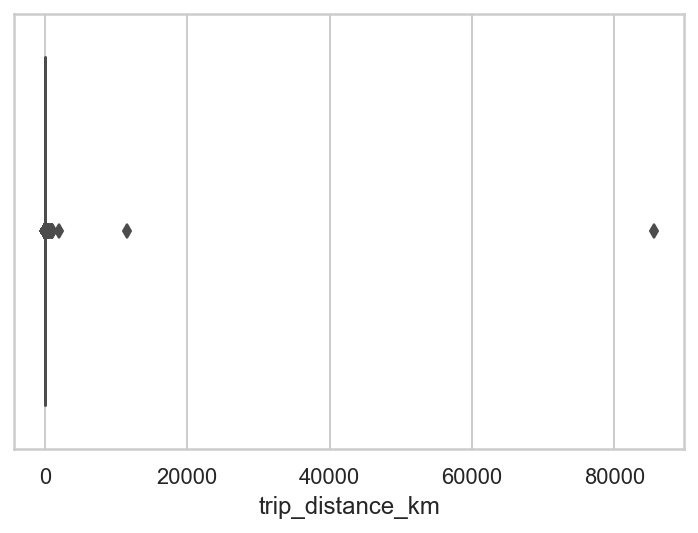

In [92]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=df['trip_distance_km'])

<AxesSubplot:xlabel='trip_distance_km'>

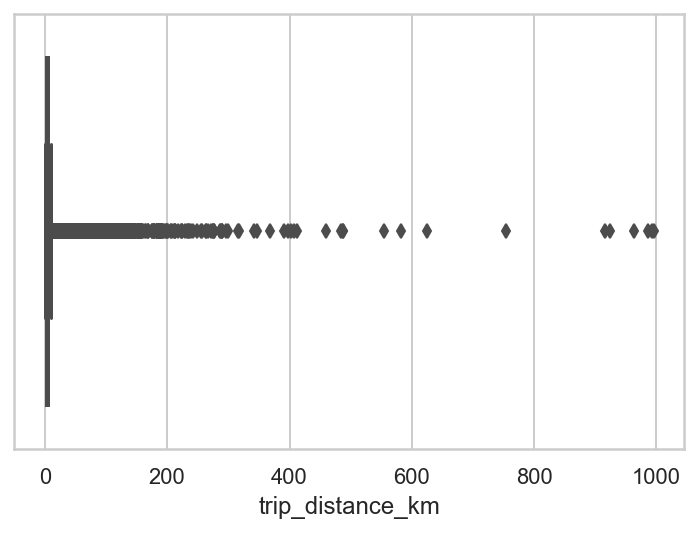

In [91]:
sns.boxplot(x=df[df['trip_distance_km'] <= 1000]['trip_distance_km'])

In [ ]:
# cut of at maximum (Q3 + 1.5*IQR)
Q1 = df_trip_distance['value']


In [51]:
df["total_amount"].value_counts().sort_index()

-895.30       1
-600.30       1
-556.85       1
-500.29       1
-480.30       1
             ..
 900.30       1
 1141.20      1
 1228.95      1
 1783.85      1
 401095.62    1
Name: total_amount, Length: 14171, dtype: int64

<AxesSubplot:xlabel='total_amount'>

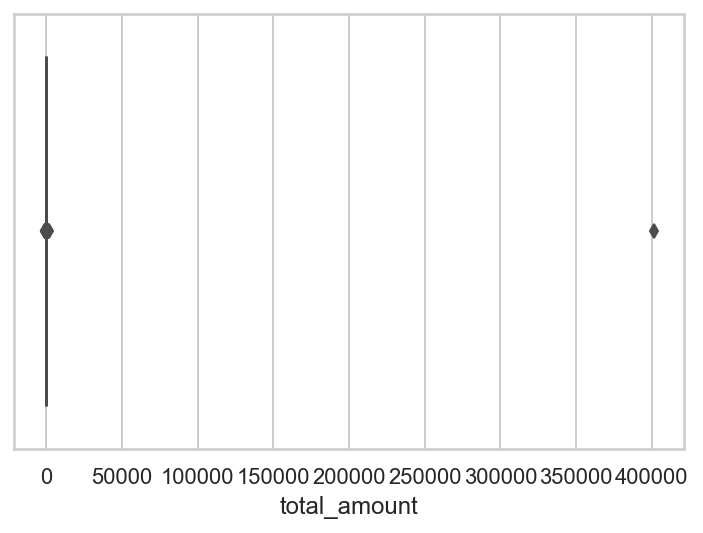

In [52]:
sns.boxplot(x=df['total_amount'])

In [58]:
# how many are below 0
df_total_amount = df["total_amount"].value_counts().sort_index()

In [62]:
df_total_amount = df_total_amount.reset_index()

In [69]:
df_total_amount.rename(columns={'index': 'value'}, inplace=True)

In [74]:
df_total_amount[df_total_amount['value'] <= 0]

,value,total_amount
0,-895.30,1
1,-600.30,1
2,-556.85,1
3,-500.29,1
4,-480.30,1
...,...,...
1170,-0.78,1
1171,-0.35,3
1172,-0.31,5
1173,-0.30,21


In [77]:
df_total_amount[df_total_amount['value'] >= 250].head(20)

,value,total_amount
13485,250.00,1
13486,250.30,29
13487,250.32,2
13488,250.38,1
13489,250.55,1
13490,250.60,1
13491,250.80,3
13492,250.96,1
13493,251.00,3
13494,251.05,1


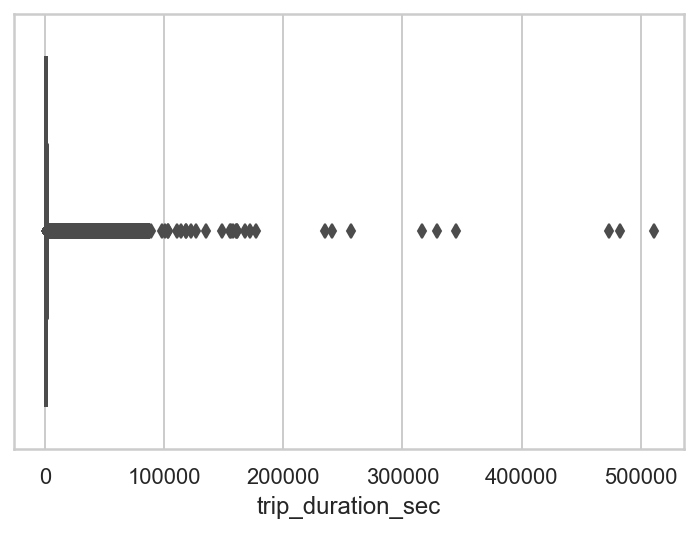

In [109]:
ax = sns.boxplot(x=df[df['trip_duration_sec'] >= 0]['trip_duration_sec'])

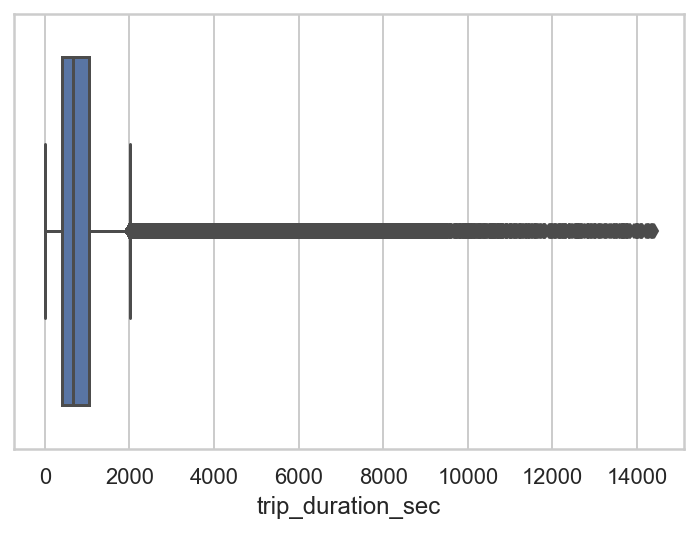

In [110]:
# 14400 sec = 240min = 4h
ax = sns.boxplot(x=df[(df.trip_duration_sec >= 0) & (df.trip_duration_sec <= 14400)]['trip_duration_sec'])

<AxesSubplot:xlabel='total_amount'>

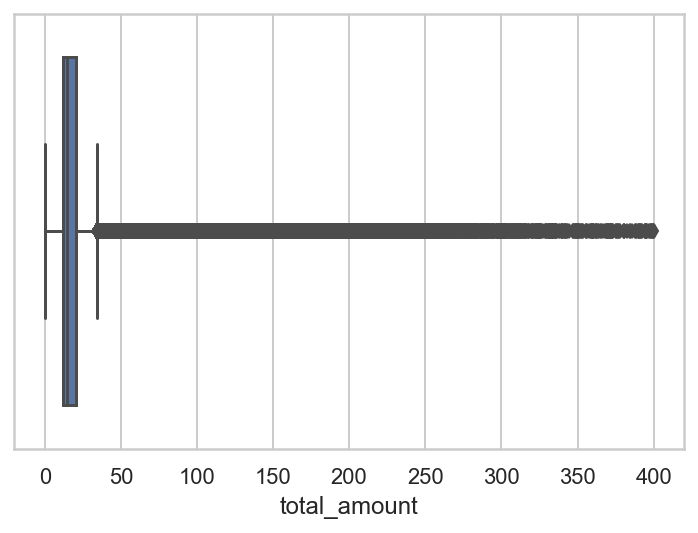

In [125]:
sns.boxplot(x=df[(df.total_amount >= 0) & (df.total_amount <= 400)]["total_amount"])

<AxesSubplot:xlabel='tip_amount'>

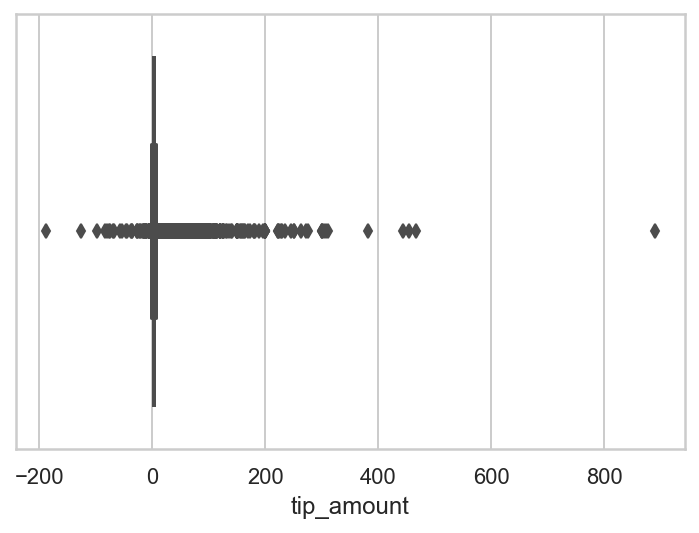

In [123]:
sns.boxplot(x=df.tip_amount)

<AxesSubplot:xlabel='tip_amount'>

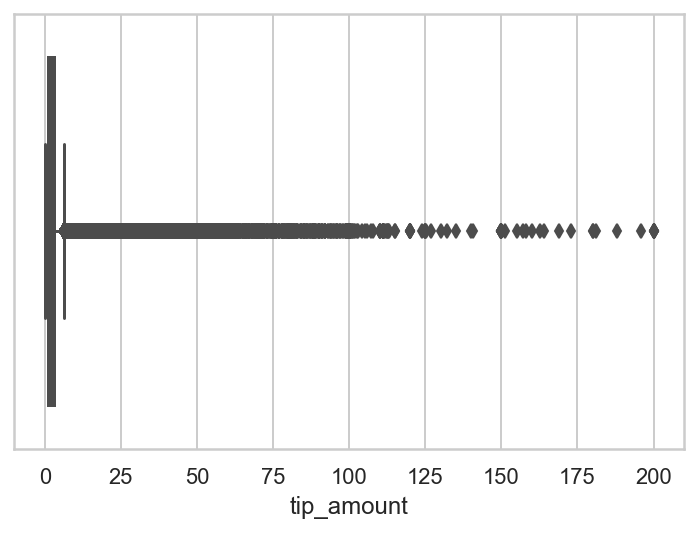

In [122]:
sns.boxplot(x=df[(df.tip_amount >= 0) & (df.tip_amount <= 200)]["tip_amount"])

In [31]:
df[df["tip_amount"] == -188.0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone
4548276,2,2022-02-21 15:53:02,2022-02-21 16:04:15,1.0,0.96,1.0,N,48,186,4,-8.5,0.0,-0.5,-188.0,0.0,-0.3,-199.8,-2.5,0.0,Manhattan,Clinton East,Yellow Zone,Manhattan,Penn Station/Madison Sq West,Yellow Zone


In [37]:
df[df["total_amount"] == 401095.62]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone
429859,1,2022-01-07 11:36:43,2022-01-07 11:47:12,1.0,3.3,1.0,N,107,140,4,401092.32,2.5,0.5,0.0,0.0,0.3,401095.62,2.5,0.0,Manhattan,Gramercy,Yellow Zone,Manhattan,Lenox Hill East,Yellow Zone


In [11]:
df[df["trip_distance"] == 53440.55]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone
8054108,2,2022-03-24 13:56:56,2022-03-24 13:58:14,1.0,53440.55,5.0,N,193,193,1,26.55,0.0,0.5,5.47,0.0,0.3,34.77,0.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone


In [35]:
# Wie viele habe negative ammounts
df[df["total_amount"] < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone
154,2,2022-01-01 00:26:37,2022-01-01 00:39:35,1.0,7.38,1.0,N,132,265,4,-21.00,-0.5,-0.5,0.00,0.0,-0.3,-23.55,0.0,-1.25,Queens,JFK Airport,Airports,Unknown,None,None
521,2,2022-01-01 00:27:18,2022-01-01 00:40:50,1.0,5.14,1.0,N,152,48,4,-17.00,-0.5,-0.5,0.00,0.0,-0.3,-20.80,-2.5,0.00,Manhattan,Manhattanville,Boro Zone,Manhattan,Clinton East,Yellow Zone
523,2,2022-01-01 00:59:33,2022-01-01 01:14:09,4.0,5.37,5.0,N,50,265,2,-75.00,0.0,0.0,0.00,0.0,-0.3,-77.80,-2.5,0.00,Manhattan,Clinton West,Yellow Zone,Unknown,None,None
580,2,2022-01-01 00:16:58,2022-01-01 00:19:41,1.0,0.46,1.0,N,90,234,2,-4.00,-0.5,-0.5,0.00,0.0,-0.3,-7.80,-2.5,0.00,Manhattan,Flatiron,Yellow Zone,Manhattan,Union Sq,Yellow Zone
714,2,2022-01-01 00:29:12,2022-01-01 00:40:29,1.0,3.13,1.0,N,13,246,4,-12.00,-0.5,-0.5,0.00,0.0,-0.3,-15.80,-2.5,0.00,Manhattan,Battery Park City,Yellow Zone,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064310,2,2022-03-30 08:11:00,2022-03-30 08:12:00,NaN,0.08,NaN,None,79,79,0,-38.31,0.0,0.5,5.55,0.0,0.3,-29.46,NaN,NaN,Manhattan,East Village,Yellow Zone,Manhattan,East Village,Yellow Zone
9066657,2,2022-03-30 21:35:00,2022-03-30 21:37:00,NaN,0.15,NaN,None,146,7,0,-18.06,0.0,0.5,2.58,0.0,0.3,-14.68,NaN,NaN,Queens,Long Island City/Queens Plaza,Boro Zone,Queens,Astoria,Boro Zone
9067712,2,2022-03-31 07:41:00,2022-03-31 07:43:00,NaN,0.48,NaN,None,80,80,0,-55.27,0.0,0.5,9.63,0.0,0.3,-44.84,NaN,NaN,Brooklyn,East Williamsburg,Boro Zone,Brooklyn,East Williamsburg,Boro Zone
9068673,2,2022-03-31 12:29:31,2022-03-31 12:33:57,NaN,0.50,NaN,None,264,170,0,-35.40,0.0,0.5,10.00,0.0,0.3,-22.10,NaN,NaN,Unknown,NV,None,Manhattan,Murray Hill,Yellow Zone


In [23]:
df.passenger_count.describe()

count    8.780189e+06
mean     1.390163e+00
std      9.794085e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

The encoding for Paymant_type is different then to the docu.
In the docu it starts with 1, but here the data code starts from 0. I assume that 0=1, 1=2, and so forth

In [38]:
df.payment_type.value_counts()

1    6956059
2    1745160
0     291055
3      40417
4      38550
5          3
Name: payment_type, dtype: int64

99 is not defined for `RatecodeID`. 
Possible meaning: ?

In [32]:
df.RatecodeID.value_counts()

1     8407017
2      264023
5       48974
99      32477
3       16999
4       10628
6          71
Name: RatecodeID, dtype: int64

In [40]:
df[df["RatecodeID"] == 99.0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULocation_Borough,PULocation_Zone,PULocation_service_zone,DOLocation_Borough,DOLocation_Zone,DOLocation_service_zone
3587,1,2022-01-01 00:10:40,2022-01-01 00:56:08,1.0,0.0,99.0,N,49,136,1,52.2,0.0,0.5,0.0,6.55,0.3,59.55,0.0,0.0,Brooklyn,Clinton Hill,Boro Zone,Bronx,Kingsbridge Heights,Boro Zone
8172,1,2022-01-01 01:11:42,2022-01-01 01:34:48,1.0,4.2,99.0,N,254,69,1,23.2,0.0,0.5,0.0,0.00,0.3,24.00,0.0,0.0,Bronx,Williamsbridge/Olinville,Boro Zone,Bronx,East Concourse/Concourse Village,Boro Zone
8173,1,2022-01-01 01:49:58,2022-01-01 02:12:27,1.0,5.1,99.0,N,213,41,1,23.2,0.0,0.5,0.0,0.00,0.3,24.00,0.0,0.0,Bronx,Soundview/Castle Hill,Boro Zone,Manhattan,Central Harlem,Boro Zone
8523,1,2022-01-01 01:02:36,2022-01-01 01:36:11,1.0,0.0,99.0,N,77,127,1,53.2,0.0,0.5,0.0,6.55,0.3,60.55,0.0,0.0,Brooklyn,East New York/Pennsylvania Avenue,Boro Zone,Manhattan,Inwood,Boro Zone
8524,1,2022-01-01 01:53:03,2022-01-01 02:06:10,1.0,1.6,99.0,N,74,238,1,15.2,0.0,0.5,0.0,0.00,0.3,16.00,0.0,0.0,Manhattan,East Harlem North,Boro Zone,Manhattan,Upper West Side North,Yellow Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8946521,1,2022-03-31 22:20:42,2022-03-31 23:00:08,1.0,0.0,99.0,N,116,39,1,60.2,0.0,0.5,0.0,6.55,0.3,67.55,0.0,0.0,Manhattan,Hamilton Heights,Boro Zone,Brooklyn,Canarsie,Boro Zone
8947468,1,2022-03-31 22:35:26,2022-03-31 23:17:18,1.0,0.0,99.0,N,74,23,1,68.2,0.0,0.5,0.0,14.00,0.3,83.00,0.0,0.0,Manhattan,East Harlem North,Boro Zone,Staten Island,Bloomfield/Emerson Hill,Boro Zone
8947982,1,2022-03-31 22:03:26,2022-03-31 22:33:14,1.0,0.0,99.0,N,79,10,1,46.2,0.0,0.5,0.0,6.55,0.3,53.55,0.0,0.0,Manhattan,East Village,Yellow Zone,Queens,Baisley Park,Boro Zone
8950611,1,2022-03-31 23:27:38,2022-03-31 23:46:35,1.0,5.7,99.0,N,140,47,1,32.2,0.0,0.5,0.0,0.00,0.3,33.00,0.0,0.0,Manhattan,Lenox Hill East,Yellow Zone,Bronx,Claremont/Bathgate,Boro Zone


Data Quality summary:
- there are some strange datapoints
- since I have a lot of data I will remove these possible corrupt datapoints

### Data Cleaning
Strategy:
- `trip_distance` remove trips <= 0 and >= 100
- `trip_duration_sec` remove trips <= 30 and >= 14400 (4h)
- `total_amount` remove amounts <=0 and >= 400
- `tip_amount` remove tips <= 0 and >= 200
- `average_speed_km/h` remove average speed <1 und >=100

In [167]:
df = df[(df.trip_distance > 0) & (df.trip_distance <= 100)]

In [168]:
df = df[(df.trip_duration_sec >= 30) & (df.trip_duration_sec <= 14400)]

In [170]:
df = df[(df.total_amount >= 0) & (df.total_amount <= 400)]

In [173]:
df = df[df.tip_amount <= 200]

<AxesSubplot:xlabel='average_speed_km/h'>

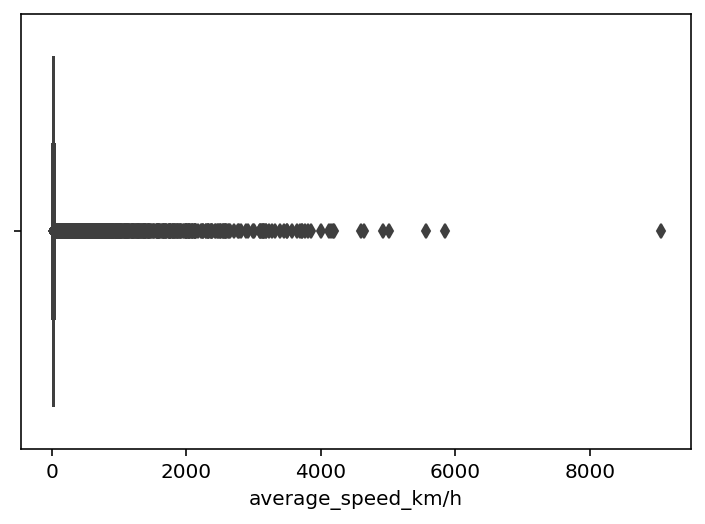

In [17]:
sns.boxplot(x=df['average_speed_km/h'])

<AxesSubplot:xlabel='average_speed_km/h'>

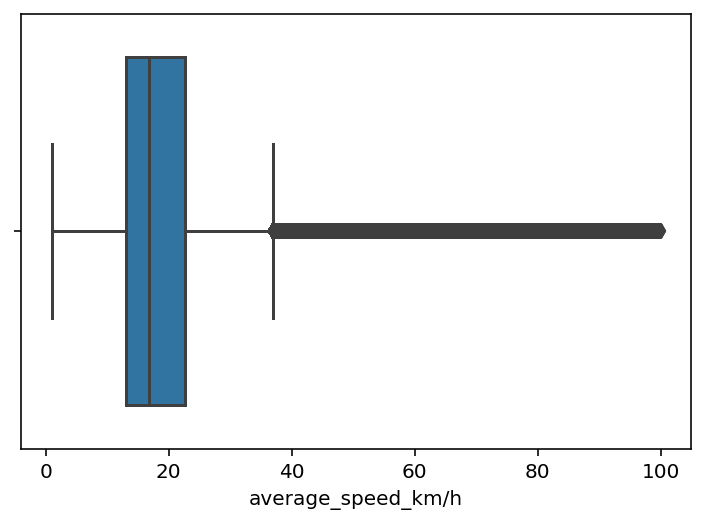

In [24]:
sns.boxplot(x=df[(df['average_speed_km/h'] >= 1) & (df['average_speed_km/h'] <= 100)]['average_speed_km/h'])

In [25]:
df = df[(df['average_speed_km/h'] >= 1) & (df['average_speed_km/h'] <= 100)]

In [26]:
df.shape

(8609011, 29)

In [29]:
# check values
for row in num_rows_list:
    print(f"{row}: min: {df[row].min()}, max: {df[row].max()}")

passenger_count: min: 0, max: 9
trip_distance: min: 0.01, max: 99.46
trip_duration: min: 0 days 00:00:30, max: 0 days 03:59:50
trip_duration_sec: min: 30.000000000000004, max: 14390.0
average_speed_km/h: min: 1.0017391304347825, max: 99.96859122401848
fare_amount: min: 0.0, max: 397.5
extra: min: 0.0, max: 33.5
mta_tax: min: 0.0, max: 17.1
tip_amount: min: 0.0, max: 200.0
improvement_surcharge: min: 0.0, max: 0.3
total_amount: min: 0.0, max: 399.55
congestion_surcharge: min: 0.0, max: 2.75
airport_fee: min: 0.0, max: 1.25


In [31]:
# save clean data
df.to_parquet("NYC_clean_data.parpuet")

In [32]:
# clear all variables to free up memory space
%reset

## Data Visualizations

In [191]:
# imports
# relaod imports after reset
import pandas as pd
# turn off truncating display option
pd.set_option('display.max_columns', None)
import numpy as np

### Libs for viszalization
import matplotlib#
import matplotlib.pyplot as plt#

import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [34]:
# reload propocessed and clean data
df = pd.read_parquet("NYC_clean_data.parpuet")

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8609011 entries, 0 to 8953429
Data columns (total 29 columns):
 #   Column                   Dtype          
---  ------                   -----          
 0   VendorID                 int64          
 1   tpep_pickup_datetime     datetime64[ns] 
 2   tpep_dropoff_datetime    datetime64[ns] 
 3   passenger_count          int64          
 4   trip_distance            float64        
 5   RatecodeID               int64          
 6   store_and_fwd_flag       object         
 7   PULocationID             int64          
 8   DOLocationID             int64          
 9   payment_type             int64          
 10  fare_amount              float64        
 11  extra                    float64        
 12  mta_tax                  float64        
 13  tip_amount               float64        
 14  tolls_amount             float64        
 15  improvement_surcharge    float64        
 16  total_amount             float64        
 17  congesti

In [75]:
df['month'] = df['tpep_pickup_datetime'].dt.month_name()

In [76]:
df[['tpep_pickup_datetime', 'month']]

,tpep_pickup_datetime,month
0,2022-01-01 00:35:40,January
1,2022-01-01 00:33:43,January
2,2022-01-01 00:53:21,January
3,2022-01-01 00:25:21,January
4,2022-01-01 00:36:48,January
...,...,...
8953425,2022-03-31 23:06:29,March
8953426,2022-03-31 23:33:04,March
8953427,2022-03-31 23:03:08,March
8953428,2022-03-31 23:31:48,March


In [48]:
# add day of trip
df['dayofweek'] = df['tpep_pickup_datetime'].dt.day_name()

In [49]:
df[['tpep_pickup_datetime', 'dayofweek']]

,tpep_pickup_datetime,dayofweek
0,2022-01-01 00:35:40,Saturday
1,2022-01-01 00:33:43,Saturday
2,2022-01-01 00:53:21,Saturday
3,2022-01-01 00:25:21,Saturday
4,2022-01-01 00:36:48,Saturday
...,...,...
8953425,2022-03-31 23:06:29,Thursday
8953426,2022-03-31 23:33:04,Thursday
8953427,2022-03-31 23:03:08,Thursday
8953428,2022-03-31 23:31:48,Thursday


### Trips per Month

In [77]:
df.month.value_counts()

March       3440705
February    2823546
January     2344684
April            32
December         28
May              16
Name: month, dtype: int64

It seems there are more corrupted records, since I only have data from January, February and March, it should be impossible to habe data from April, May and December
- December: trips that srarted on the 31.12.2021 at 23:52 

In [82]:
df = df[(df.month != 'December') & (df.month != 'April') & (df.month != 'May')]

In [86]:
df_trips_per_month = df.month.value_counts()
df_trips_per_month = df_trips_per_month.reset_index()
df_trips_per_month.rename(columns={'index': 'month', 'month': 'count'}, inplace=True)
df_trips_per_month

,month,count
0,March,3440705
1,February,2823546
2,January,2344684


In [87]:
df_trips_per_month = df_trips_per_month.reindex([2, 1, 0])

<AxesSubplot:xlabel='month', ylabel='count'>

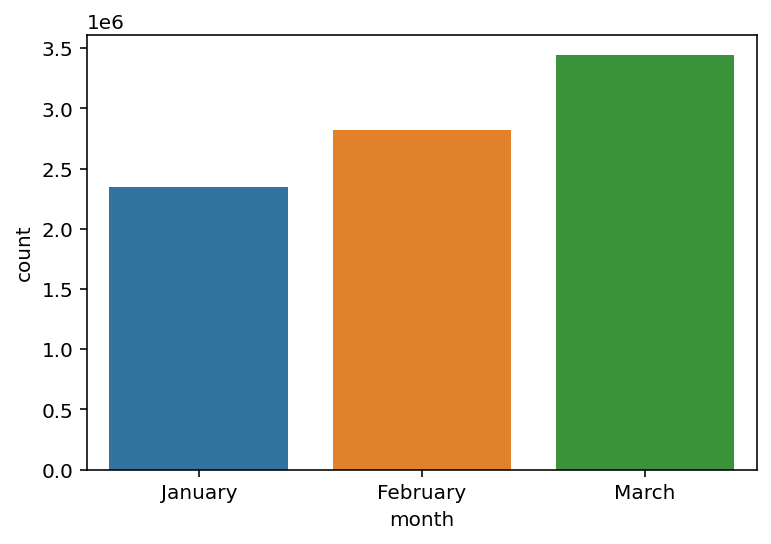

In [88]:
sns.barplot(x=df_trips_per_month.month, y=df_trips_per_month['count'])

### Trips per Day

In [61]:
df_trips_per_day = df.dayofweek.value_counts()
df_trips_per_day = df_trips_per_day.reset_index()
df_trips_per_day.rename(columns={'index': 'dayofweek', 'dayofweek': 'count'}, inplace=True)

In [68]:
df_trips_per_day

,dayofweek,count
0,Thursday,1359148
1,Wednesday,1302872
2,Friday,1264190
3,Saturday,1257901
4,Tuesday,1250652
5,Monday,1113974
6,Sunday,1060274


In [72]:
df_trips_per_day = df_trips_per_day.reindex([5, 4, 1, 0, 2, 3, 6])

<AxesSubplot:xlabel='dayofweek', ylabel='count'>

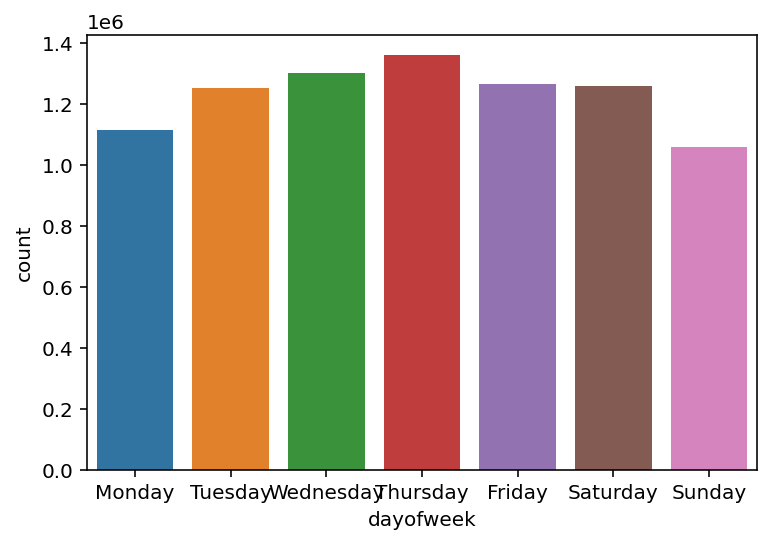

In [73]:
sns.barplot(x=df_trips_per_day.dayofweek, y=df_trips_per_day['count'])

### Trips per Hour

In [92]:
df_trips_per_hour = df.tpep_pickup_datetime.dt.hour.value_counts().sort_index()


In [93]:
df_trips_per_hour

0     215986
1     144589
2      96042
3      66162
4      41670
5      46480
6     125734
7     252538
8     340853
9     374536
10    409181
11    440256
12    480374
13    497419
14    542240
15    567671
16    562292
17    608887
18    634538
19    559195
20    457673
21    431993
22    400988
23    311638
Name: tpep_pickup_datetime, dtype: int64

<AxesSubplot:>

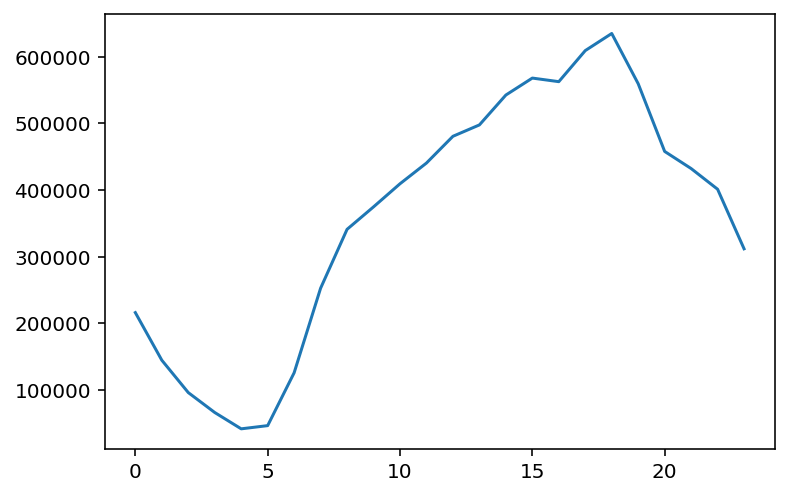

In [95]:
sns.lineplot(x=df_trips_per_hour.index, y=df_trips_per_hour.values)

### What is the most common pickup place?

In [124]:
df_common_pickup_places = df['PULocationID'].value_counts()
df_common_pickup_places = df_common_pickup_places.reset_index()
df_common_pickup_places.rename(columns={'index': 'PULocationID', 'PULocationID': 'count'}, inplace=True)

In [125]:
df_common_pickup_places

,PULocationID,count
0,237,420496
1,236,393975
2,132,346030
3,161,344769
4,186,289065
...,...,...
253,105,2
254,27,2
255,30,2
256,99,1


In [122]:
df_taxi_zones = pd.read_csv("taxi+_zone_lookup.csv")

In [123]:
df_taxi_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [126]:
df_common_pickup_places.merge(df_taxi_zones, left_on='PULocationID', right_on='LocationID')

,PULocationID,count,LocationID,Borough,Zone,service_zone
0,237,420496,237,Manhattan,Upper East Side South,Yellow Zone
1,236,393975,236,Manhattan,Upper East Side North,Yellow Zone
2,132,346030,132,Queens,JFK Airport,Airports
3,161,344769,161,Manhattan,Midtown Center,Yellow Zone
4,186,289065,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone
...,...,...,...,...,...,...
253,105,2,105,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
254,27,2,27,Queens,Breezy Point/Fort Tilden/Riis Beach,Boro Zone
255,30,2,30,Queens,Broad Channel,Boro Zone
256,99,1,99,Staten Island,Freshkills Park,Boro Zone


mapping

In [128]:
import shapefile as shp

#### Geopandas

In [137]:
import geopandas as gpd

In [140]:
fp = "taxi_zones/taxi_zones.shp"
map_df = gpd.read_file(fp)

map_df

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


#### Join map_df with df_common_pickup_places

In [161]:
df_common_pickup_places

,PULocationID,count
0,237,420496
1,236,393975
2,132,346030
3,161,344769
4,186,289065
...,...,...
253,105,2
254,27,2
255,30,2
256,99,1


In [168]:
df_merged_pickup = map_df.merge(df_common_pickup_places, right_on='PULocationID', left_on='LocationID')

In [172]:
df_merged_pickup.sample(5)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,count
227,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22...",236,393975
29,30,0.094510,0.000146,Broad Channel,30,Queens,"POLYGON ((1034013.272 163473.152, 1034866.459 ...",30,2
82,85,0.057475,0.000144,Erasmus,85,Brooklyn,"POLYGON ((998911.565 178131.302, 998946.909 17...",85,126
94,97,0.062476,0.000163,Fort Greene,97,Brooklyn,"POLYGON ((992751.699 192765.140, 992899.310 19...",97,2757
43,44,0.235689,0.001945,Charleston/Tottenville,44,Staten Island,"POLYGON ((925284.273 142075.259, 924921.951 14...",44,61


<AxesSubplot:>

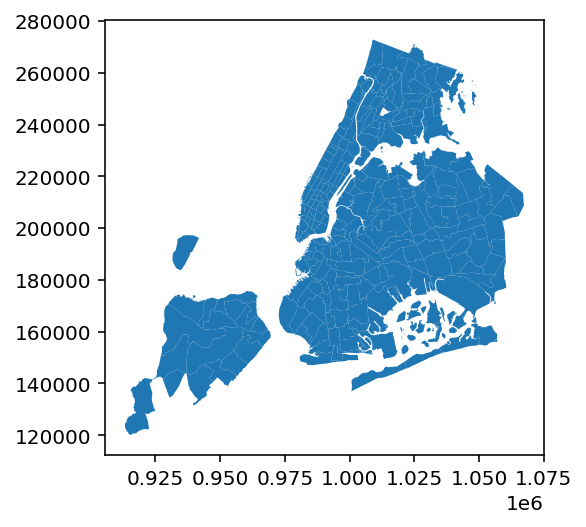

In [171]:
df_merged_pickup.plot()

,zone,count
228,Upper East Side South,420496
227,Upper East Side North,393975
154,Midtown Center,344769
179,Penn Station/Madison Sq West,289065
135,Lincoln Square East,285280
...,...,...
187,Randalls Island,224
194,Roosevelt Island,168
146,Marble Hill,79
121,Inwood Hill Park,25


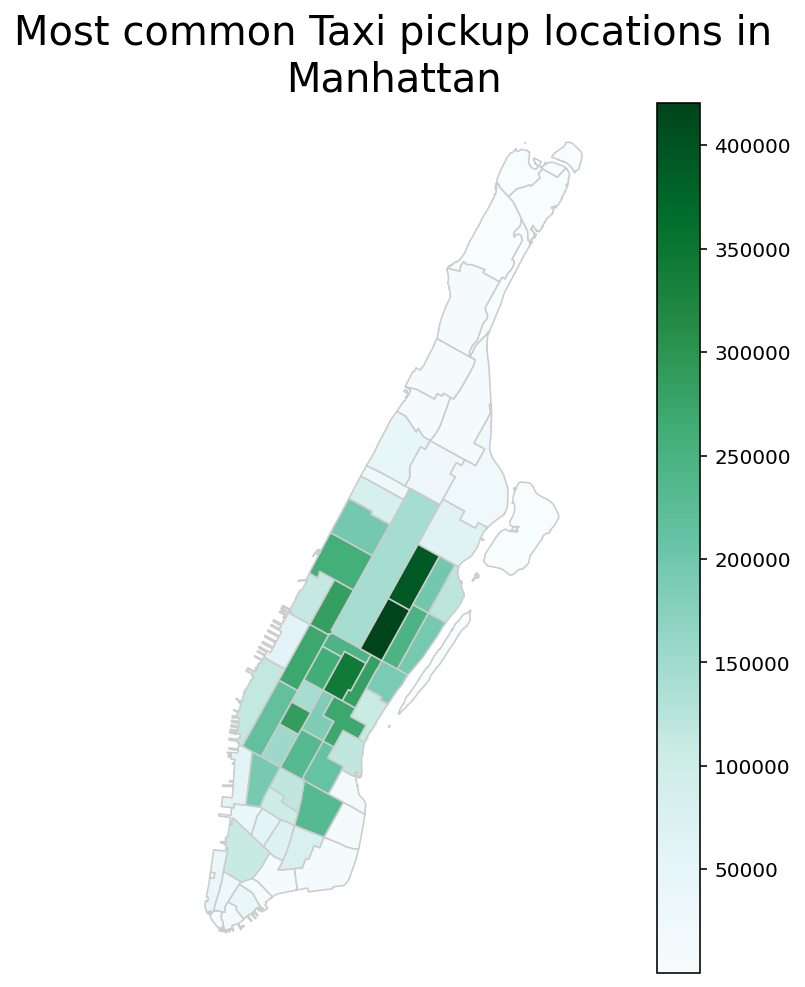

In [195]:
variable = 'count'
fig, ax = plt.subplots(1, figsize=(10,8))
ax.axis('off')
ax.set_title('Most common Taxi pickup locations in\nManhattan', fontdict={'fontsize': '20'})

vmin = df_merged_pickup[df_merged_pickup.borough == 'Manhattan']['count'].min()
vmax = df_merged_pickup[df_merged_pickup.borough == 'Manhattan']['count'].max()

sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

df_merged_pickup[df_merged_pickup.borough == 'Manhattan'].plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
df_merged_pickup[df_merged_pickup.borough == 'Manhattan'][['zone', 'count']].sort_values(by='count', ascending=False)

,zone,count
125,JFK Airport,346030
131,LaGuardia Airport,222958
68,East Elmhurst,31930
217,Sunnyside,6572
139,Long Island City/Queens Plaza,4557
...,...,...
244,Willets Point,9
93,Forest Park/Highland Park,6
1,Jamaica Bay,6
26,Breezy Point/Fort Tilden/Riis Beach,2


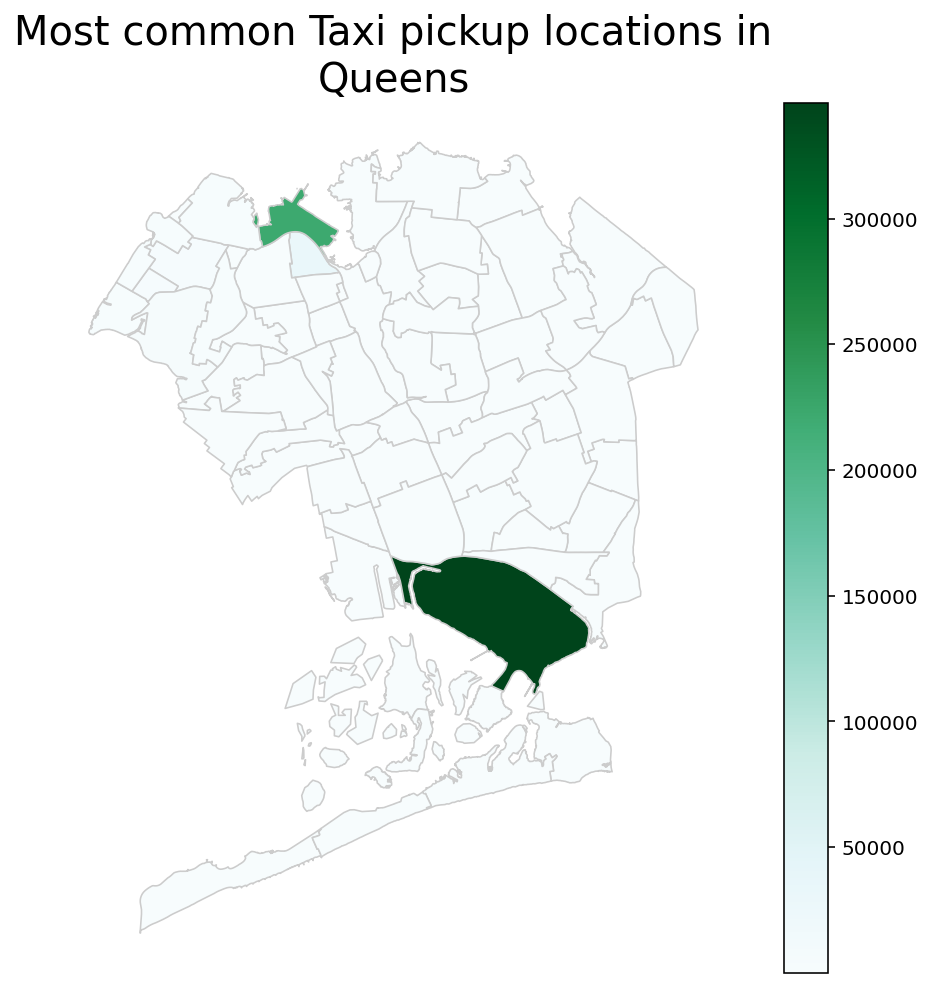

In [196]:
variable = 'count'
#vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(10,8))
ax.axis('off')
ax.set_title('Most common Taxi pickup locations in\nQueens', fontdict={'fontsize': '20'})

vmin = df_merged_pickup[df_merged_pickup.borough == 'Queens']['count'].min()
vmax = df_merged_pickup[df_merged_pickup.borough == 'Queens']['count'].max()

sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

df_merged_pickup[df_merged_pickup.borough == 'Queens'].plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')

df_merged_pickup[df_merged_pickup.borough == 'Queens'][['zone', 'count']].sort_values(by='count', ascending=False)

In [200]:
df_merged_pickup[df_merged_pickup.borough == "Bronx"].explore(column="count", tooltip=['zone', 'count'])

<AxesSubplot:>

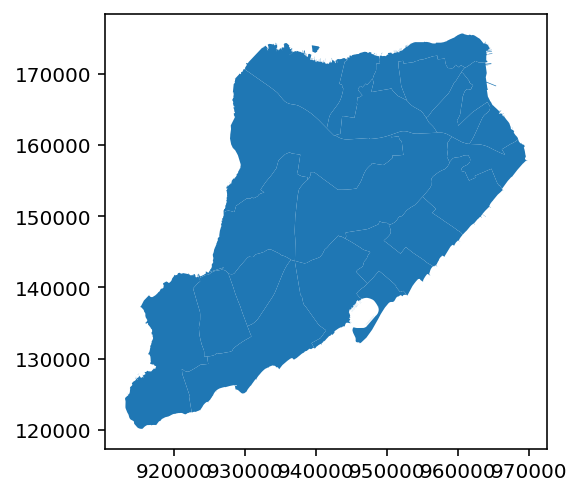

In [149]:
map_df[map_df.borough == "Staten Island"].plot()

<AxesSubplot:>

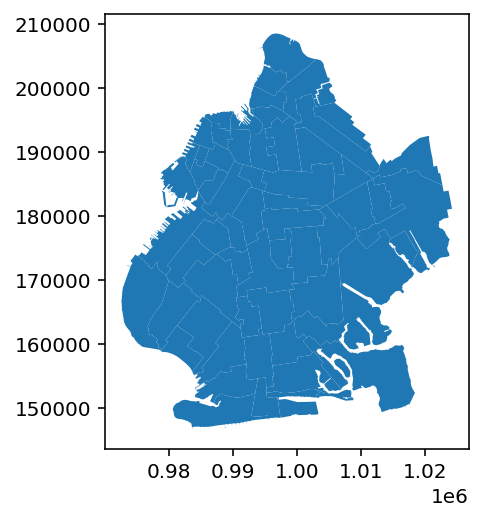

In [150]:
map_df[map_df.borough == "Brooklyn"].plot()

#### What is the most common dorpoff place?

### What is the most travled location from the airport?

In [106]:
df[(df['PULocation_service_zone'] == 'Airports') | (df['PULocation_service_zone'] == 'EWR')]['PULocation_Zone'].value_counts()

JFK Airport          346030
LaGuardia Airport    222958
Newark Airport          104
Name: PULocation_Zone, dtype: int64